# Twitter Data Analysis 

## Table of Contents
- [Data Wrangling](#wrang)
- [Analysis](#analysis)

<a id='wrang'></a>
# Data Wrangling


## Gather Data


In [1]:
import requests
import pandas as pd
import numpy as np
import tweepy
import matplotlib.pyplot as plt
import csv 
import json
import os
import warnings
import seaborn as sns
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

#### 1. Download image_predictions.tsv

In [2]:
if 'image_predictions.tsv' not in os.listdir():
    url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

    r = requests.get(url)
    open('image_predictions.tsv', 'wb').write(r.content)

In [3]:
im_pred_orig = pd.read_csv('image_predictions.tsv', delimiter= '\t')
im_pred_orig.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### 2. Retrieve Twitter API Data

In [4]:
archive_orig = pd.read_csv('twitter-archive-enhanced.csv')
archive_orig.shape

(2356, 17)

In [6]:
if 'tweet_json.txt' not in os.listdir():
    
    # collect data
    tweet_fail_id = np.array([])
    count = 0

    with open('tweet_json.txt', 'w') as export_file:

        for t_id in archive['tweet_id']:
            count += 1

            try:
                auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
                auth.set_access_token(access_token, access_secret)
                api = tweepy.API(auth)

                tweet = api.get_status(t_id, tweet_mode='extended')

                export_file.write(json.dumps(tweet._json))
                export_file.write('\n')

                if count == 500:
                    print('500 Successes')

            except tweepy.TweepError as e:
                tweet_fail_id = np.append(tweet_fail_id, t_id)


In [7]:
# reformat data into df
count_df_orig = pd.DataFrame(columns = ['tweet_id','retweet_count','favorite_count'])

with open('tweet_json.txt') as file:
    for ind, line in enumerate(file):
        tweet = json.loads(line)
        t_id = tweet['id_str']
        retweet_count = tweet['retweet_count']
        like_count = tweet['favorite_count']
        count_df_orig.loc[ind] = np.array([t_id, retweet_count, like_count])
        
count_df_orig.shape

(1556, 3)

In [8]:
count_df_orig.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7260,34716
1,892177421306343426,5434,30085
2,891815181378084864,3583,22640
3,891689557279858688,7465,37993
4,891327558926688256,8018,36276


## Assess

#### Quality:
1. remove non-original tweets (retweet or reply)
2. re-extract ratings from text and update df and change dtypes
3. drop rows with 0 as denominator and change denominators to 10
4. change tweet id to categorical
5. change favorite counts and retweet counts to numerical 
6. delete duplicated pictures from image prediction
7. remove columns not necessary
8. combine all dataframes together with same tweet_id
9. remove ones with no picture

In [9]:
archive = archive_orig.copy()
archive.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [10]:
#1. remove non-original tweets
# retweet
nas = archive[['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']].isna().sum(axis = 1)
archive = archive[nas == 3]

# in_reply
nas = archive[['in_reply_to_status_id', 'in_reply_to_user_id']].isna().sum(axis = 1)
archive = archive[nas == 2]

In [11]:
#2. re-extract ratings from text 
r = archive['text'].str.extract('((?:\d+\.)?\d+)\/(\d+)', expand = True)
r.columns = ['rating_numerator', 'rating_denominator']
r['rating_numerator'] = r['rating_numerator'].astype(float)
r['rating_denominator'] = r['rating_denominator'].astype(int)
(r['rating_numerator'] != archive['rating_numerator']).sum()

4

In [12]:
#3. modify denominators on condition to make it 10
im_pred = im_pred_orig.copy()
denom_not10 = archive[archive['rating_denominator'] != 10]['tweet_id']
denom_not10_df = im_pred[im_pred['tweet_id'].astype(str).apply(lambda x: 
                                             True if (x == denom_not10.astype('str')).sum() == 1 else False)]
len(denom_not10)

17

In [13]:
# check images to find a solution for those denominators != 10
denom_not10_df['tweet_id'] =denom_not10_df['tweet_id'].astype(float)
denom_not10_df2 = denom_not10_df[['tweet_id','jpg_url']].sort_values(by = 'tweet_id')

a = archive[archive['rating_denominator'] != 10][['tweet_id','rating_numerator','rating_denominator']]
a['tweet_id'] = a['tweet_id'].astype(float)
a2 = a[['tweet_id','rating_numerator','rating_denominator']].sort_values(by = 'tweet_id')

pd.merge(denom_not10_df2, a2, on = 'tweet_id').head()

<ipython-input-13-62383c266140>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  denom_not10_df['tweet_id'] =denom_not10_df['tweet_id'].astype(float)


,tweet_id,jpg_url,rating_numerator,rating_denominator
0,6.662874e+17,https://pbs.twimg.com/media/CT8g3BpUEAAuFjg.jpg,1,2
1,6.758531e+17,https://pbs.twimg.com/media/CWEcxqWVEAAHyGH.jpg,88,80
2,6.777165e+17,https://pbs.twimg.com/media/CWe7kw9W4AE8UJh.jpg,144,120
3,6.829620e+17,https://pbs.twimg.com/media/CXpeVzQW8AApKYb.jpg,7,11
4,6.842229e+17,https://pbs.twimg.com/media/CX7Y_ByWwAEJdUy.jpg,121,110


In [14]:
# divide denom and numerator by 10 if it is divisible and different than 10 otherwise return nan
def div_denom(r):
    if r['rating_denominator'] == 10:
        return r
    elif (r['rating_denominator'] % 10) == 0:
        dogs = int(r['rating_denominator'] / 10)
        r['rating_denominator'] = r['rating_denominator'] / dogs
        r['rating_numerator'] = r['rating_numerator'] / dogs
        return r
    else:
        return np.nan

archive = archive.apply(div_denom, axis = 1, result_type = 'broadcast')

In [15]:
# drop columns where rating denominator is not 10
archive = archive[~pd.isna(archive['rating_denominator'])]
archive.rating_denominator.value_counts()

10    2093
Name: rating_denominator, dtype: int64

In [16]:
#4. change favorite counts and retweet counts to numerical 
count_df = count_df_orig.copy()
count_df.retweet_count = count_df.retweet_count.astype(int)
count_df.favorite_count = count_df.favorite_count.astype(int)

In [17]:
#5. remove columns not necessary
archive = archive[['tweet_id', 'timestamp','text', 'rating_numerator',
                   'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo']]

In [18]:
#6. change tweet id to categorical
archive['tweet_id'] = archive['tweet_id'].astype('str')
im_pred['tweet_id'] = im_pred['tweet_id'].astype('str')
count_df['tweet_id'] = count_df['tweet_id'].astype('str')

In [19]:
#7. delete duplicated pictures from image prediction
print(im_pred.drop('tweet_id', axis = 1).duplicated().sum())
tid = im_pred['tweet_id']
im_pred = im_pred.drop('tweet_id', axis = 1).drop_duplicates()
im_pred = pd.concat([tid, im_pred], axis = 1)

66


In [20]:
#8. combine all dataframes together with same tweet_id
print(count_df.shape, im_pred.shape)

(1556, 3) (2075, 12)


In [21]:
combined = count_df.merge(im_pred, how='inner', on='tweet_id')
combined = combined.merge(archive, how='inner', on='tweet_id')
combined.shape

(1295, 23)

In [22]:
combined.columns

Index(['tweet_id', 'retweet_count', 'favorite_count', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'timestamp', 'text', 'rating_numerator', 'rating_denominator',
       'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [23]:
#9. inconsistent alphabet case over p1 ~ p3 -> change to lowercase
for i in range(1, 4):
    combined[f'p{i}'] = combined[f'p{i}'].str.lower()
    
combined.head()

,tweet_id,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,...,p3_dog,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,7260,34716,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,False,bagel,0.085851,...,False,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None
1,892177421306343426,5434,30085,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,chihuahua,0.323581,True,pekinese,0.090647,...,True,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None
2,891815181378084864,3583,22640,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,chihuahua,0.716012,True,malamute,0.078253,...,True,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None
3,891689557279858688,7465,37993,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,paper_towel,0.170278,False,labrador_retriever,0.168086,...,False,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None
4,891327558926688256,8018,36276,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,basset,0.555712,True,english_springer,0.225770,...,True,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None


In [24]:
#10. make dog stages columns into one
stage = combined[['doggo','floofer','pupper','puppo']].applymap(lambda x: 0 if x == 'None' else 1)
stage['None'] = (stage.sum(axis = 1) < 1).apply(lambda x: 1 if x else 0)
stage['stage'] = stage.idxmax(1)
combined = pd.concat([combined.drop(columns = ['doggo','floofer','pupper','puppo']), stage['stage']], axis = 1)

In [25]:
combined['stage'].value_counts()

None       1126
pupper      100
doggo        50
puppo        16
floofer       3
Name: stage, dtype: int64

In [26]:
# 11. rename columns in the format -> lowercase_lowercase, and create rating ratio 
combined['rating_ratio'] = (combined['rating_numerator']/combined['rating_denominator']).astype(float)
combined = combined.drop(columns = ['rating_numerator', 'rating_denominator'], axis = 1)
combined = combined.rename(columns = {'timestamp': 'time_stamp', 
                                      'text': 'tweet_content',
                                      'name':'dog_name', 
                                      'stage': 'age_stage',
                                      'jpg_url': 'picture_url'})

In [27]:
combined.columns

Index(['tweet_id', 'retweet_count', 'favorite_count', 'picture_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'time_stamp', 'tweet_content', 'dog_name', 'age_stage',
       'rating_ratio'],
      dtype='object')

In [28]:
#12. final clean up of dtypes
combined['img_num'] = combined['img_num'].astype(int)

In [29]:
combined.head()

,tweet_id,retweet_count,favorite_count,picture_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,time_stamp,tweet_content,dog_name,age_stage,rating_ratio
0,892420643555336193,7260,34716,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,Phineas,None,1.3
1,892177421306343426,5434,30085,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,Tilly,None,1.3
2,891815181378084864,3583,22640,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,Archie,None,1.2
3,891689557279858688,7465,37993,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,Darla,None,1.3
4,891327558926688256,8018,36276,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,Franklin,None,1.2


In [30]:
combined.dtypes

tweet_id           object
retweet_count       int32
favorite_count      int32
picture_url        object
img_num             int32
p1                 object
p1_conf           float64
p1_dog             object
p2                 object
p2_conf           float64
p2_dog             object
p3                 object
p3_conf           float64
p3_dog             object
time_stamp         object
tweet_content      object
dog_name           object
age_stage          object
rating_ratio      float64
dtype: object

In [31]:
combined.isnull().sum()

tweet_id          0
retweet_count     0
favorite_count    0
picture_url       0
img_num           0
p1                0
p1_conf           0
p1_dog            0
p2                0
p2_conf           0
p2_dog            0
p3                0
p3_conf           0
p3_dog            0
time_stamp        0
tweet_content     0
dog_name          0
age_stage         0
rating_ratio      0
dtype: int64

In [66]:
# up to august 1st 
combined['time_stamp'][combined['time_stamp'].str.contains('2017-08')]

0    2017-08-01 16:23:56 +0000
1    2017-08-01 00:17:27 +0000
Name: time_stamp, dtype: object

In [39]:
combined.to_csv('twitter_archive_master.csv', index=False)

<a id='analysis'></a>
# Analysis


## Relationship between rating ratio vs. favorite count, img_num, retweet_count


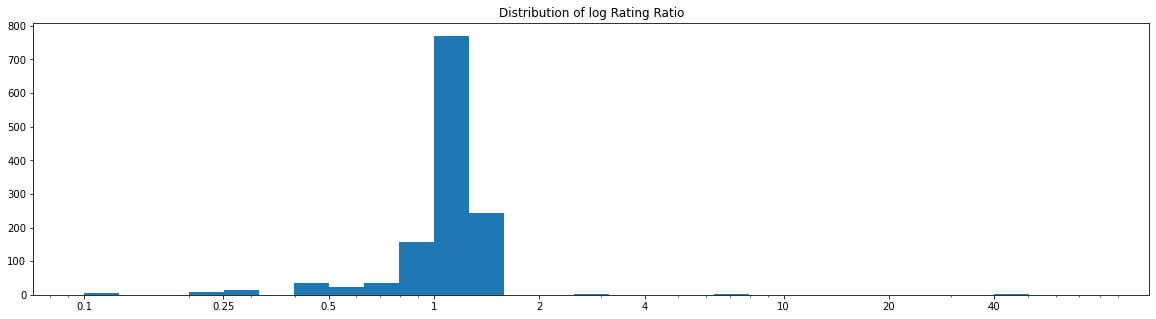

In [68]:
plt.figure(figsize = (20,5))
bins = 10** np.arange(-1, 2, 0.1)

ticks = [0.1, 0.25,0.5,1,2,4,10,20,40]
labels = [str(t) for t in ticks]

plt.hist(combined['rating_ratio'], bins= bins);
plt.xscale('log')
plt.xticks(ticks, labels);

plt.title('Distribution of log Rating Ratio');
plt.savefig('no.1.png', bbox_inches='tight')

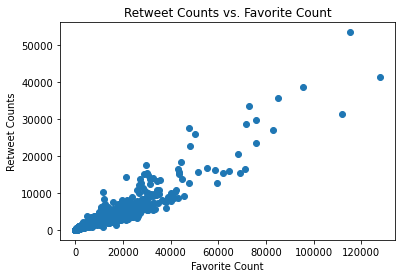

In [69]:
plt.scatter(y= combined.retweet_count,x = combined.favorite_count)
plt.title('Retweet Counts vs. Favorite Count')

plt.ylabel('Retweet Counts')
plt.xlabel('Favorite Count');
plt.savefig('no.2.png', bbox_inches='tight')

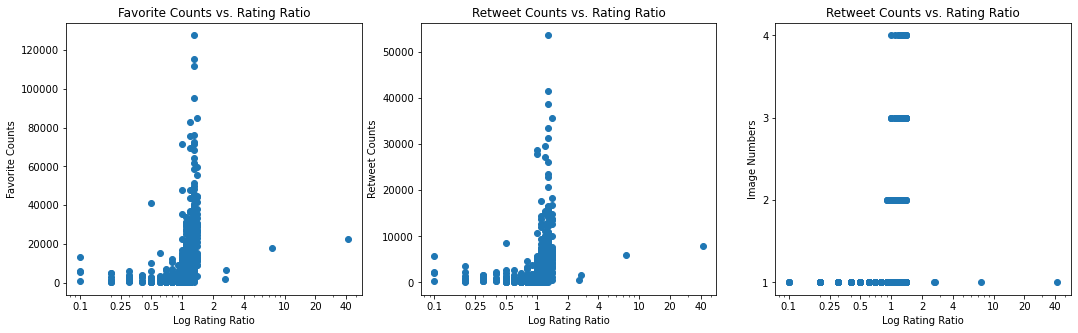

In [70]:
plt.figure(figsize = (18,5))
plt.subplot(1,3,1)
ticks = [0.1, 0.25,0.5,1,2,4,10,20,40]
labels = [str(t) for t in ticks]

plt.scatter(y= combined.favorite_count,x = combined.rating_ratio)
plt.xscale('log');
plt.title('Favorite Counts vs. Rating Ratio')
plt.xticks(ticks, labels);

plt.ylabel('Favorite Counts')
plt.xlabel('Log Rating Ratio');

plt.subplot(1,3,2)
plt.scatter(y= combined.retweet_count,x = combined.rating_ratio)
plt.xscale('log');
plt.title('Retweet Counts vs. Rating Ratio')
plt.xticks(ticks, labels);

plt.ylabel('Retweet Counts')
plt.xlabel('Log Rating Ratio');

plt.subplot(1,3,3)
plt.scatter(y  = combined.img_num, x= combined.rating_ratio)
plt.xscale('log');
plt.title('Retweet Counts vs. Rating Ratio')
plt.xticks(ticks, labels);
plt.yticks([1,2,3,4], [str(i) for i in np.arange(1,5)]);
plt.ylabel('Image Numbers')
plt.xlabel('Log Rating Ratio');

plt.savefig('no.3.png', bbox_inches='tight')

## How does number of retweets and likes relate to number of images?

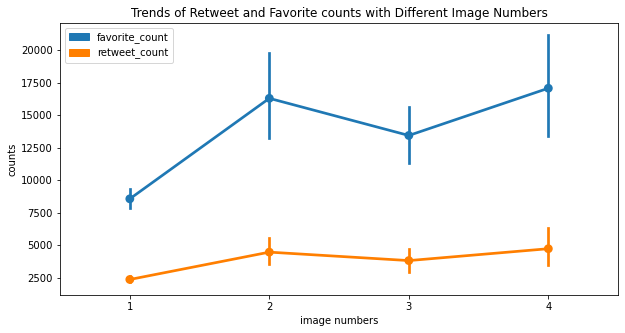

In [109]:
fig, ax = plt.subplots(figsize = (10, 5))
# combined.groupby('img_num').mean()[['retweet_count', 'favorite_count']].plot(ax = ax)
sns.pointplot(x="img_num", y="favorite_count", data=combined, ax = ax, label = 'favorite_count', color = sns.color_palette('Paired')[1])
sns.pointplot(x="img_num", y="retweet_count", data=combined, ax = ax, label = 'retweet_count', color = sns.color_palette('Paired')[-5])

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color=sns.color_palette('Paired')[1], label='favorite_count')
black_patch = mpatches.Patch(color=sns.color_palette('Paired')[-5], label='retweet_count')
plt.legend(handles=[red_patch, black_patch])

plt.xlabel('image numbers')
plt.ylabel('counts')
plt.title('Trends of Retweet and Favorite counts with Different Image Numbers');
plt.savefig('no.4.png', bbox_inches='tight')

## What kind of dogs are predicted the most?


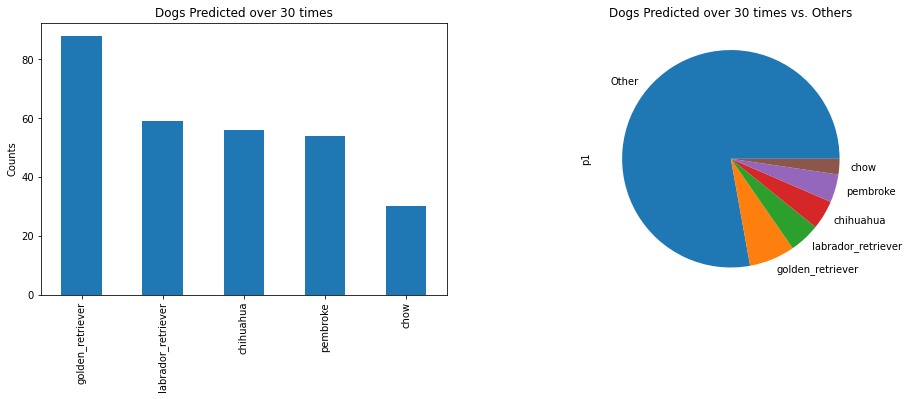

In [72]:
plt.figure(figsize = (16, 5))

plt.subplot(1,2,1)
count_dog = combined['p1'].value_counts()
count_dog[count_dog >= 30].plot(kind ='bar')
plt.title('Dogs Predicted over 30 times');
plt.ylabel('Counts');

plt.subplot(1,2,2)
combined['p1'].apply(lambda x: x if x in count_dog.index[:5] else 'Other').value_counts().plot(kind = 'pie')
plt.title('Dogs Predicted over 30 times vs. Others')
plt.savefig('no.5.png', bbox_inches='tight')

# Do people like puppies more or older dogs more?

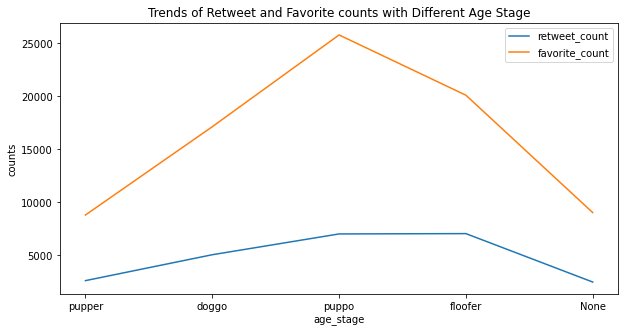

In [110]:
fig, ax = plt.subplots(figsize = (10, 5))

combined.groupby('age_stage').mean()[['retweet_count', 'favorite_count'
                                     ]].loc[['pupper', 'doggo', 'puppo','floofer', 'None']].plot(ax= ax)
plt.xticks(list(range(0,5)), ['pupper', 'doggo', 'puppo','floofer', 'None'])
plt.ylabel('counts')
plt.title('Trends of Retweet and Favorite counts with Different Age Stage');
plt.savefig('no.6.png', bbox_inches='tight')

## Hypothesis Test: Does Rating differ if dog is predicted as a dog?

$\mu_f$ = rating_ratio for falsely predicted dog<br>
$\mu_t$ = rating_ratio for truely predicted dog


$$H_0: \mu_{t} - \mu_{f} = 0$$
$$H_1: \mu_{t} - \mu_{f} \neq 0$$

In [111]:
def calculate_p_vlaue(combined, col):
    muf = mut = combined['rating_ratio'].mean()
    n_f = combined.groupby(col).count()['tweet_id'][False]
    n_t = combined.groupby(col).count()['tweet_id'][True]
    
    mu_diffs = np.array([])
    std = combined['rating_ratio'].std()

    for _ in range(10000):

        false_dog = np.random.normal(muf, std, n_f)
        true_dog = np.random.normal(mut, std, n_t)

        mu_diffs = np.append(mu_diffs, (true_dog.mean()- false_dog.mean()))
    
    
    actual_rat = combined.groupby(col).mean()[['rating_ratio']]
    actual_diff = actual_rat.loc[True] - actual_rat.loc[False]
#     null_vals = np.random.normal(0, mu_diffs.std(), 10000)
    plt.hist(mu_diffs, )
    plt.axvline(actual_diff.values[0], c = 'red');
    plt.title(f'Distribution under H0 Hypothesis: {col}')
    plt.show()
    
    print(f'CI: {np.percentile(mu_diffs,2.5)} ~ {np.percentile(mu_diffs,97.5)}')
    print(f'Acutal diff: {actual_diff.values[0]}')
    plt.savefig(f'no.{col}.png', bbox_inches='tight')
    if np.percentile(mu_diffs,2.5) > actual_diff.values[0] or np.percentile(mu_diffs,97.5) < actual_diff.values[0]:
        print('Reject Null hypothesis, rating_ratio is different')
    else:
        print('Do not Reject Null hypothesis, rating_ratio is not different')

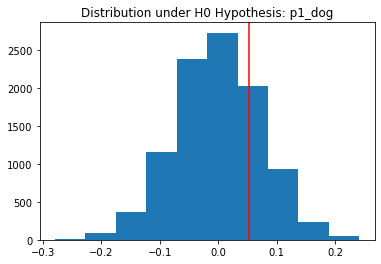

CI: -0.1445485316613067 ~ 0.14211593812773707
Acutal diff: 0.053316936944582505
Do not Reject Null hypothesis, rating_ratio is not different


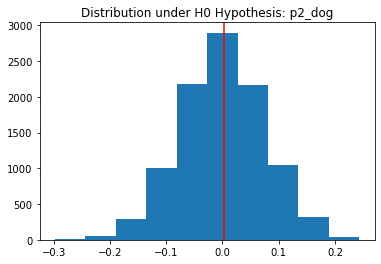

CI: -0.14742515107069631 ~ 0.14558674359594043
Acutal diff: 0.0034996684557595525
Do not Reject Null hypothesis, rating_ratio is not different


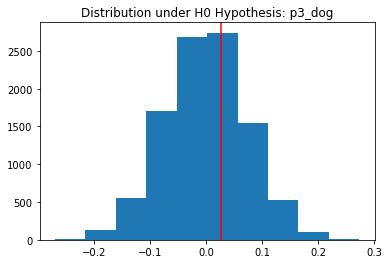

CI: -0.14192711908046923 ~ 0.14255082831947397
Acutal diff: 0.027177105184301276
Do not Reject Null hypothesis, rating_ratio is not different


<Figure size 432x288 with 0 Axes>

In [112]:
for i in range(1,4):
    calculate_p_vlaue(combined, f'p{i}_dog')